In [1]:
import torch
import torch.nn as nn
import torchaudio
from torchaudio.datasets import YESNO
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import random

## Dataset

The YESNO dataset is a widely used dataset in the field of speech recognition and audio processing. It consists of 60 audio recordings of a single speaker, each recording containing a sequence of eight spoken words, where the words are either "yes" or "no" in Hebrew.


In [2]:
YESNO_DATASET_PATH = os.path.join("../data", "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)

In [3]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()


In [4]:
yesno_data = YESNO(YESNO_DATASET_PATH, download=False) # download=True will download the dataset from the internet

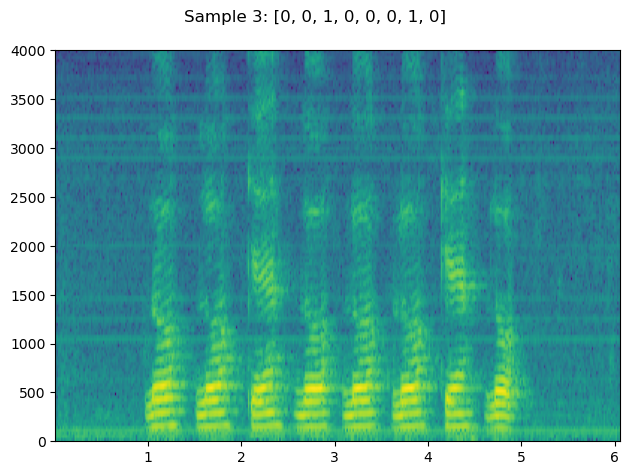

In [5]:
i = 3
waveform, sample_rate, label = yesno_data[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
ipd.Audio(waveform, rate=sample_rate)


In [6]:
train_size = int(0.8 * len(yesno_data))
test_size = len(yesno_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(yesno_data, [train_size, test_size])

In [7]:
def pad_sequence(batch, target_len=56000):
    """Pad or randomly chop the waveforms to exactly 7 seconds (56,000 samples)."""
    batch_waveforms = []
    
    for waveform in batch:
        waveform_len = waveform.size(1)
        
        if waveform_len > target_len:
            # Randomly select a start point to chop a segment of 7 seconds
            start_idx = random.randint(0, waveform_len - target_len)
            waveform = waveform[:, start_idx:start_idx + target_len]
        elif waveform_len < target_len:
            # Pad with zeros if it's shorter than 7 seconds
            padding = target_len - waveform_len
            waveform = nn.functional.pad(waveform, (0, padding))
        
        batch_waveforms.append(waveform)
    
    # Stack the processed waveforms into a single tensor
    return torch.stack(batch_waveforms)

# Update the collate function to use the new padding method
def collate_fn_pad(batch):
    waveforms, labels = zip(*[(d[0], torch.tensor(d[2])) for d in batch])
    waveforms = pad_sequence(waveforms, 7 * sample_rate) # 7 seconds
    labels = torch.stack(labels)
    return waveforms, labels

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_pad)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_pad)

In [8]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.linear(x)

In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        total_loss = 0
        for waveforms, labels in train_loader:
            outputs = model(waveforms)
            loss = criterion(outputs, labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


In [10]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in data_loader:
            outputs = model(waveforms)
            predicted = torch.round(torch.sigmoid(outputs))  # Binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {correct / (total * 8):.4f}')  # Total 8 labels per sample


In [11]:
# Model, loss function, optimizer
input_size = 56000  # Approximate input size (depending on padding)
output_size = 8  # 8 outputs, one for each word
model = LogisticRegressionModel(input_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.6928
Epoch [2/10], Loss: 0.6907
Epoch [3/10], Loss: 0.6886
Epoch [4/10], Loss: 0.6866
Epoch [5/10], Loss: 0.6845
Epoch [6/10], Loss: 0.6825
Epoch [7/10], Loss: 0.6805
Epoch [8/10], Loss: 0.6785
Epoch [9/10], Loss: 0.6764
Epoch [10/10], Loss: 0.6744


In [12]:
# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 0.5000


In [13]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

# Feedforward model
hidden_size = 256
model = FeedforwardNN(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch [1/10], Loss: 0.6938
Epoch [2/10], Loss: 0.4441
Epoch [3/10], Loss: 0.2729
Epoch [4/10], Loss: 0.1623
Epoch [5/10], Loss: 0.0946
Epoch [6/10], Loss: 0.0531
Epoch [7/10], Loss: 0.0319
Epoch [8/10], Loss: 0.0197
Epoch [9/10], Loss: 0.0126
Epoch [10/10], Loss: 0.0083


In [14]:
# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 0.5833


In [18]:
class CNN(nn.Module):
    def __init__(self, output_size, input_length=56000):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2, 2)  # Reduces the length by half
        
        # Calculate the flattened size after convolutions and pooling
        conv_output_length = self._get_conv_output_length(input_length)
        
        self.fc1 = nn.Linear(conv_output_length * 32, 512)
        self.fc2 = nn.Linear(512, output_size)

    def _get_conv_output_length(self, input_length):
        # Function to calculate the length of the output after the conv and pooling layers
        conv1_length = input_length // 2  # First maxpool divides by 2
        conv2_length = conv1_length // 2  # Second maxpool divides by 2 again
        return conv2_length

    def forward(self, x):
        x = x  # Add a channel dimension for Conv1d
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first conv and pool
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second conv and pool
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))  # First fully connected layer
        return self.fc2(x)  # Output layer


# CNN model
model = CNN(output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch [1/10], Loss: 6.7233
Epoch [2/10], Loss: 3.4474
Epoch [3/10], Loss: 1.5248
Epoch [4/10], Loss: 0.9306
Epoch [5/10], Loss: 0.7248
Epoch [6/10], Loss: 0.7326
Epoch [7/10], Loss: 0.6836
Epoch [8/10], Loss: 0.7028
Epoch [9/10], Loss: 0.6852
Epoch [10/10], Loss: 0.6641


In [19]:
# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 0.4271


In [26]:
import torchaudio.transforms as transforms

# Define the MelSpectrogram transformation
mel_spectrogram_transform = transforms.MelSpectrogram(
    sample_rate=8000,  # YESNO dataset has a sample rate of 8000 Hz
    n_mels=128,        # Number of mel bands (you can adjust this)
    n_fft=1024,        # FFT window size
    hop_length=256     # Hop length for the sliding window
)

def waveform_to_mel_spectrogram(waveform):
    """Convert waveform to mel-spectrogram and then to decibels."""
    spectrogram = mel_spectrogram_transform(waveform)
    
    # Convert the amplitude spectrogram to decibel (dB) scale
    spectrogram = torchaudio.functional.amplitude_to_DB(
        spectrogram, 
        multiplier=10.0,    # Standard for dB scale conversion
        amin=1e-10,         # Minimum amplitude
        db_multiplier=0.0   # Zero dB reference
    )
    return spectrogram

def pad_sequence_spectrogram(batch, target_len=219):
    """Pad or randomly chop spectrograms to a fixed time length (219 frames)."""
    batch_spectrograms = []
    
    for spectrogram in batch:
        time_len = spectrogram.size(2)
        
        if time_len > target_len:
            # Randomly chop the spectrogram along the time dimension
            start_idx = random.randint(0, time_len - target_len)
            spectrogram = spectrogram[:, :, start_idx:start_idx + target_len]
        elif time_len < target_len:
            # Pad with zeros if shorter than target time length
            padding = target_len - time_len
            spectrogram = nn.functional.pad(spectrogram, (0, padding))
        
        batch_spectrograms.append(spectrogram)
    
    # Stack the processed spectrograms into a tensor
    return torch.stack(batch_spectrograms)

# Update the collate function for spectrograms
def collate_fn_spectrogram(batch):
    """Convert waveforms to mel-spectrograms, apply padding/chopping, and return labels."""
    waveforms, labels = zip(*[(d[0], torch.tensor(d[2])) for d in batch])
    
    # Convert each waveform to a mel-spectrogram
    spectrograms = [waveform_to_mel_spectrogram(waveform) for waveform in waveforms]
    
    # Pad or chop each spectrogram to a fixed time length (219 frames)
    spectrograms = pad_sequence_spectrogram(spectrograms, target_len=219)
    
    labels = torch.stack(labels)
    return spectrograms, labels


class SpectrogramCNN(nn.Module):
    def __init__(self, output_size):
        super(SpectrogramCNN, self).__init__()
        # Conv layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Conv layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Conv layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Flatten the output from the convolutional layers
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(27648, 512)  # Adjust the dimensions after conv layers
        self.fc2 = nn.Linear(512, output_size)

    def forward(self, x):
        # x shape: (batch_size, 1, n_mels, time_frames)
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten and pass through fully connected layers
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [29]:
# Model, loss function, optimizer
output_size = 8  # 8 output classes (for the 8-word sequences)
model = SpectrogramCNN(output_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_spectrogram)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_spectrogram)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=20)


Epoch [1/20], Loss: 7.7664
Epoch [2/20], Loss: 1.7452
Epoch [3/20], Loss: 0.7278
Epoch [4/20], Loss: 0.6875
Epoch [5/20], Loss: 0.6543
Epoch [6/20], Loss: 0.6140
Epoch [7/20], Loss: 0.5649
Epoch [8/20], Loss: 0.5275
Epoch [9/20], Loss: 0.4721
Epoch [10/20], Loss: 0.4248
Epoch [11/20], Loss: 0.3469
Epoch [12/20], Loss: 0.2821
Epoch [13/20], Loss: 0.2275
Epoch [14/20], Loss: 0.1524
Epoch [15/20], Loss: 0.1045
Epoch [16/20], Loss: 0.0729
Epoch [17/20], Loss: 0.0458
Epoch [18/20], Loss: 0.0339
Epoch [19/20], Loss: 0.0182
Epoch [20/20], Loss: 0.0127


In [30]:
# Evaluate the model
evaluate_model(model, test_loader)

Accuracy: 0.7604
